<center>
</center>
<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color:#FFFFFF;
            overflow:hidden;
            font-weight:500">Identifying Neuronal Subtypes in the Mouse Visual Cortex using scRNA-seq and UMAP Clustering</div>

**Dataset**:

[Mouse Whole Cortex + Hippocampus 10x dataset (Allen Institute)](https://portal.brain-map.org/atlases-and-data/rnaseq/mouse-whole-cortex-and-hippocampus-10x)

**Analysis Workflow**:
  
**1**. Load Expression Matrix, Metadata and filter exclusively for Primary Visual Cortex Neurons (~29000 neurons).

**2**. Data Preprocessing (normalization, log transformation, HVG selection)

**3**. Principal Components Analysis (PCA) for dimensionality reduction 

**4**. Build kNN graph and use UMAP to generate 2D embedding. 

**5**. Leiden algorithm for clustering

**6**. Marker gene identification and validation against subclass labels in the Allen dataset

## Install Packages and import them

In [1]:
# Uncomment and run if not already installed
# !pip install scanpy anndata pandas numpy matplotlib seaborn
# !pip install --user scikit-misc
# !pip install leidenalg

import scanpy as sc
import h5py
import pandas as pd
import numpy as np
from anndata import AnnData
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

## Load Gene Expression Matrix and Metadata

In [2]:
# Load HDF5 gene expression data
f = h5py.File("Mouse_WCH_10x_expression_matrix.hdf5", "r")

# Decode cell and gene names
cell_names = [s.decode() for s in f["data"]["samples"][:]]
gene_names = [g.decode() for g in f["data"]["gene"][:]]

print(f"Expression matrix: {len(gene_names)} genes × {len(cell_names)} cells")

Expression matrix: 31053 genes × 1169320 cells


In [3]:
#Show a small slice of the count matrix (5 genes × 5 cells)
subset = f["data"]["counts"][:5, :5]
df_subset = pd.DataFrame(subset, index=gene_names[:5], columns=cell_names[:5])

# Display Head
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
display(df_subset)

,AAACCTGAGAAACGCC-L8TX_180221_01_F09,AAACCTGAGAAGGTTT-L8TX_180221_01_F09,AAACCTGAGAGTAATC-L8TX_180221_01_F09,AAACCTGAGCCTTGAT-L8TX_180221_01_F09,AAACCTGAGTGGTAAT-L8TX_180221_01_F09
Xkr4,8,13,8,11,10
Gm1992,0,2,0,0,1
Gm37381,0,0,0,0,0
Rp1,0,0,0,0,0
Sox17,0,0,0,0,0


In [4]:
# Load metadata CSV
meta = pd.read_csv("metadata.csv")
print(f"Metadata: {meta.shape[0]} cells × {meta.shape[1]} annotations")

# Preview Head
display(meta.head())

Metadata: 1169213 cells × 57 annotations


,sample_name,donor_sex_id,donor_sex_label,donor_sex_color,region_id,region_label,region_color,platform_label,cluster_order,cluster_label,cluster_color,subclass_order,subclass_label,subclass_color,neighborhood_id,neighborhood_label,neighborhood_color,class_order,class_label,class_color,exp_component_name,external_donor_name_label,full_genotype_label,facs_population_plan_label,injection_roi_label,injection_materials_label,injection_method_label,injection_type_label,full_genotype_id,full_genotype_color,external_donor_name_id,external_donor_name_color,facs_population_plan_id,facs_population_plan_color,injection_materials_id,injection_materials_color,injection_method_id,injection_method_color,injection_roi_id,injection_roi_color,injection_type_id,injection_type_color,cell_type_accession_label,cell_type_alias_label,cell_type_alt_alias_label,cell_type_designation_label,cell_type_designation_id,cell_type_alt_alias_id,cell_type_alias_id,cell_type_accession_id,cell_type_designation_color,cell_type_alt_alias_color,cell_type_alias_color,cell_type_accession_color,cortical_layer_label,cortical_layer_order,cortical_layer_color
0,ACGCAGCAGACCGGAT-L8TX_180221_01_C11,2,M,#ADC4C3,20,RSP,#2B9EAD,10X,116,116_Pvalb,#EC2D46,8,Pvalb,#D93137,2,MGE,#ED892E,2,GABAergic,#F05A28,ACGCAGCAGACCGGAT-L8TX_180221_01_C11,373822,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,RFP-positive,NaN,NaN,NaN,NaN,67,#E726,454,#C14D,6,#4C2E99,1,#FF7373,1,#FF7373,1,#FF7373,1,#FF7373,CS202106160_116,116_Pvalb,NaN,CTX-HPF 116,116,116,116,116,#EC2D46,#EC2D46,#EC2D46,#EC2D46,NaN,1,#FF7373
1,CCATGTCAGCGCTTAT-L8TX_180221_01_C11,2,M,#ADC4C3,20,RSP,#2B9EAD,10X,364,364_DG,#413BE2,36,DG,#394FD3,7,DG/SUB/CA,#9AB7E2,1,Glutamatergic,#00ADEE,CCATGTCAGCGCTTAT-L8TX_180221_01_C11,373822,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,RFP-positive,NaN,NaN,NaN,NaN,67,#E726,454,#C14D,6,#4C2E99,1,#FF7373,1,#FF7373,1,#FF7373,1,#FF7373,CS202106160_364,364_DG,NaN,CTX-HPF 364,364,364,364,364,#413BE2,#413BE2,#413BE2,#413BE2,NaN,1,#FF7373
2,GCGCAGTAGTGTCTCA-L8TX_180712_01_H05,2,M,#ADC4C3,21,TEa-PERI-ECT,#76CBE2,10X,18,18_Lamp5,#D97C80,3,Lamp5,#DA808C,1,CGE,#CC93C2,2,GABAergic,#F05A28,GCGCAGTAGTGTCTCA-L8TX_180712_01_H05,395345,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,RFP-positive,NaN,NaN,NaN,NaN,67,#E726,507,#99177F,6,#4C2E99,1,#FF7373,1,#FF7373,1,#FF7373,1,#FF7373,CS202106160_18,18_Lamp5,NaN,CTX-HPF 018,18,18,18,18,#D97C80,#D97C80,#D97C80,#D97C80,NaN,1,#FF7373
3,GTCACGGCACCAACCG-L8TX_180712_01_H05,2,M,#ADC4C3,21,TEa-PERI-ECT,#76CBE2,10X,15,15_Lamp5,#A6666F,3,Lamp5,#DA808C,1,CGE,#CC93C2,2,GABAergic,#F05A28,GTCACGGCACCAACCG-L8TX_180712_01_H05,395345,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,RFP-positive,NaN,NaN,NaN,NaN,67,#E726,507,#99177F,6,#4C2E99,1,#FF7373,1,#FF7373,1,#FF7373,1,#FF7373,CS202106160_15,15_Lamp5,NaN,CTX-HPF 015,15,15,15,15,#A6666F,#A6666F,#A6666F,#A6666F,NaN,1,#FF7373
4,ATTGGACTCGATCCCT-L8TX_180712_01_A06,2,M,#ADC4C3,21,TEa-PERI-ECT,#76CBE2,10X,18,18_Lamp5,#D97C80,3,Lamp5,#DA808C,1,CGE,#CC93C2,2,GABAergic,#F05A28,ATTGGACTCGATCCCT-L8TX_180712_01_A06,395345,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,RFP-positive,NaN,NaN,NaN,NaN,67,#E726,507,#99177F,6,#4C2E99,1,#FF7373,1,#FF7373,1,#FF7373,1,#FF7373,CS202106160_18,18_Lamp5,NaN,CTX-HPF 018,18,18,18,18,#D97C80,#D97C80,#D97C80,#D97C80,NaN,1,#FF7373


## Select common cells present in the gene expression matrix and metadata

In [5]:
# Create a DataFrame from all sample names (loaded earlier from HDF5)
cell_df = pd.DataFrame(index=cell_names)
cell_df["sample_name"] = cell_df.index

# Merge the sample names DataFrame with metadata
# Inner join: Keeps only cells present in both gene expression and metadata
merged = pd.merge(cell_df, meta, on="sample_name", how="inner")
merged = merged.set_index("sample_name")

print(f"Merged metadata shape: {merged.shape}")

Merged metadata shape: (1169213, 56)


## Filter specifically for Primary Visual Cortex Neurons (VISp) from Metadata & Expression Matrix

In [6]:
# Filter for Excitatory (Glutamatergic) and Inhibitory (GABAergic) neurons from Primary Visual Cortex neurons
VISp_neurons = merged[
    (merged['region_label'] == 'VISp') &
    (merged['class_label'].isin(['Glutamatergic', 'GABAergic']))
]

# Get the sample names (cell barcodes)
VISp_cells = VISp_neurons.index.tolist()

#Find column indices for VISp neurons in the expression matrix
# Convert hippocampal cell list to a set for faster lookup
VISp_cell_set = set(VISp_cells)

# Much faster lookup
VISp_indices = [i for i, name in enumerate(cell_names) if name in VISp_cell_set]

print(f"Found {len(VISp_cells)} VISp neurons.")

Found 29391 VISp neurons.


## Load only VISp neurons from the expression matrix through chunking

In [7]:
# Set chunk size (e.g., 10,000 cells at a time)
chunk_size = 10000

# Sort indices to preserve matrix order
VISp_indices_sorted = sorted(VISp_indices)

# Initialize list to hold loaded slices
chunks = []

for i in range(0, len(VISp_indices_sorted), chunk_size):
    idx_chunk = VISp_indices_sorted[i:i+chunk_size]
    print(f"Loading columns {i} to {i+len(idx_chunk)}...")
    data_chunk = f["data"]["counts"][:, idx_chunk].T  # shape: chunk_size × genes
    chunks.append(data_chunk)

# Stack all chunks into final matrix
X_VISp = np.vstack(chunks)
print(f"Final matrix shape (cells × genes): {X_VISp.shape}")

Loading columns 0 to 10000...
Loading columns 10000 to 20000...
Loading columns 20000 to 29391...
Final matrix shape (cells × genes): (29391, 31053)


## Build the AnnData object for Scanpy processing

In [8]:
# Filter metadata again for hippocampal neurons
meta_VISp = merged.loc[VISp_cells]

# Sanity check to validate loaded expression data shape with metadata. 
assert X_VISp.shape[0] == len(meta_VISp)

# Load gene names again just in case (should match X_hip.shape[1])
gene_names = [g.decode() for g in f["data"]["gene"][:]]  # skip if you already have it

# Create AnnData object
adata = AnnData(X=X_VISp, obs=meta_VISp.copy(), var=pd.DataFrame(index=gene_names))
adata.obs_names = meta_VISp.index
adata.var_names_make_unique()

print(adata.shape)

(29391, 31053)


## Preprocessing (Count Normalization, Log Transformation and HVG Selection)

Number of highly variable genes: 2000


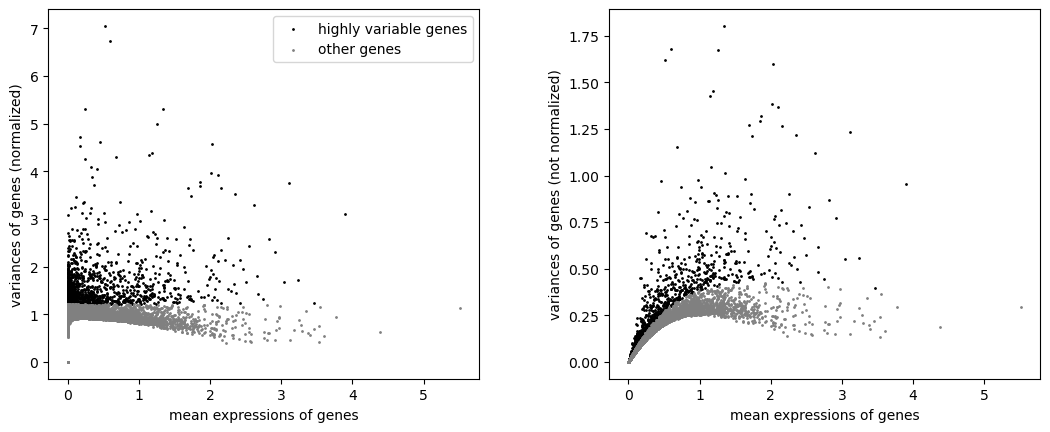

In [10]:
#Normalize the raw counts per cell so that each cell has the same total read count
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform
sc.pp.log1p(adata)

# Select top 2000 highly variable genes (this is fast now)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)
print(f"Number of highly variable genes: {adata.var['highly_variable'].sum()}")

sc.pl.highly_variable_genes(adata)

**These plots show that highly variable genes (in black) span a wide range of expression levels and have greater variance, making them ideal features for downstream analysis.**

## Keep only HVGs and scale all counts to zero mean and unit variance

In [11]:
# Keep only HVGs
adata = adata[:, adata.var['highly_variable']]

# scaling
sc.pp.scale(adata, max_value=10)

print(adata.shape)

(29391, 2000)


## Dimensionality reduction using Principal Components Analysis (PCA)

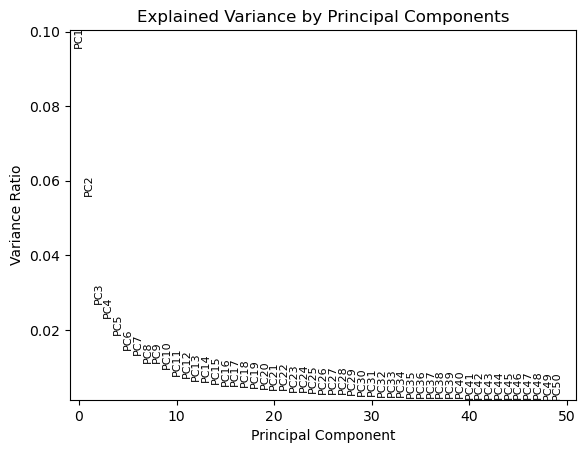

In [12]:
# -- PCA --
sc.tl.pca(adata, svd_solver='arpack')

# Plotting explained variance across 50 components
sc.pl.pca_variance_ratio(adata, log=False, n_pcs=50, show=False)

# Customize with title and axis labels
plt.title("Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio")
plt.show()

**Based on this plot, the top 12 PCs were selected for UMAP and Leiden clustering.**

## Build KNN Graph

In [13]:
# Creates a KNN Graph using top 12 Principal components and 15 nearest neighbors per cell. 

sc.pp.neighbors(adata, n_neighbors = 15, n_pcs=12)

## Obtain 2D UMAP embedding based on KNN Graph

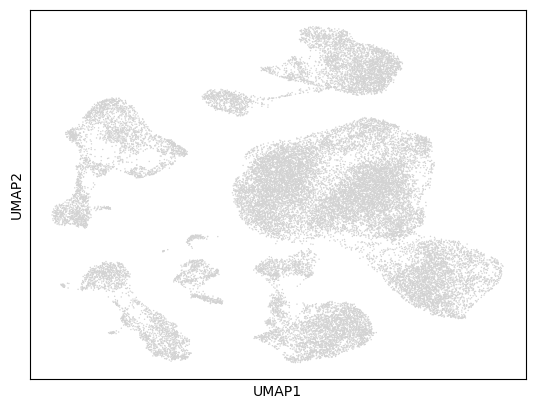

In [14]:
#Lets use UMAP to projec tthis data from 12 dimensions into 2 dimensions
sc.tl.umap(adata)

#Lets plot this. Each point is a single cell but they haven't been assigned to clusters yet. so there's no color
sc.pl.umap(adata)

## Using Leiden's algorithm for clustering the 2D UMAP Embeddings

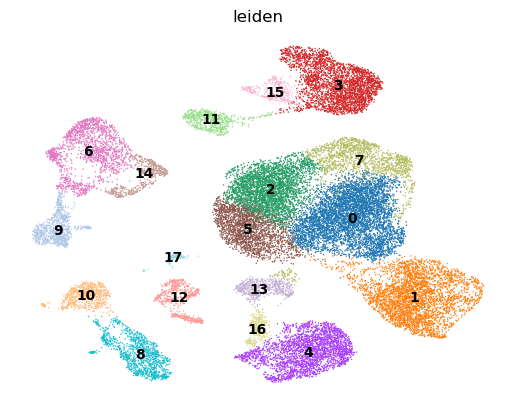

In [15]:
#To assign clustering, we need to run Leiden algorithm
#Hierarchial clustering algorithm which groups cells based on their similarity in the UMAP space
sc.tl.leiden(adata, resolution = 0.5)
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data")

## Identify marker genes for each Leiden Cluster

In [21]:
# Identify marker genes for each Leiden cluster using a modified t-test
# This compares the mean expression of each gene in a given cluster to all other clusters
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test_overestim_var')


# Extract genes that are significantly differentially expressed (FDR adjusted p-value < 0.05)
markers = sc.get.rank_genes_groups_df(adata,None)
markers = markers[(markers.pvals_adj< 0.05)]

## Broad Cluster Classification using excitory and inhibitory neurons

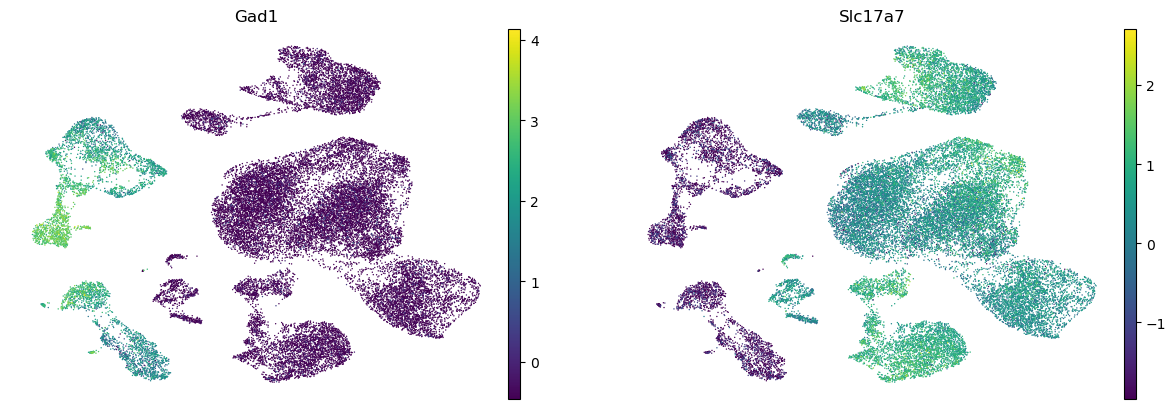

In [16]:
## Visualize expression of inhibitory (Gad1) and excitatory (Slc17a7) marker genes across clusters
sc.pl.umap(adata, color=['Gad1', 'Slc17a7'], frameon=False)

**Gad1 and  Slc17a7 are expressed in completely non-overlapping clusters — this clear separation confirms that the clustering successfully distinguishes excitatory and inhibitory neuron populations in the dataset.**

## UMAP Expression Maps of Top 3 Marker Genes for Clusters 3 & 8

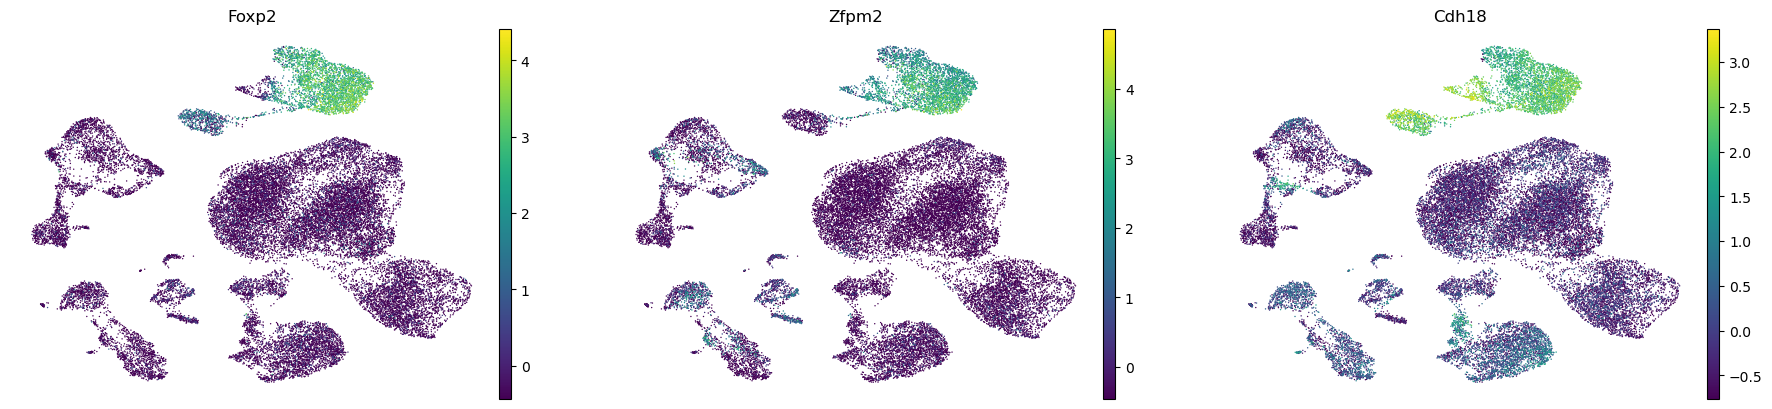

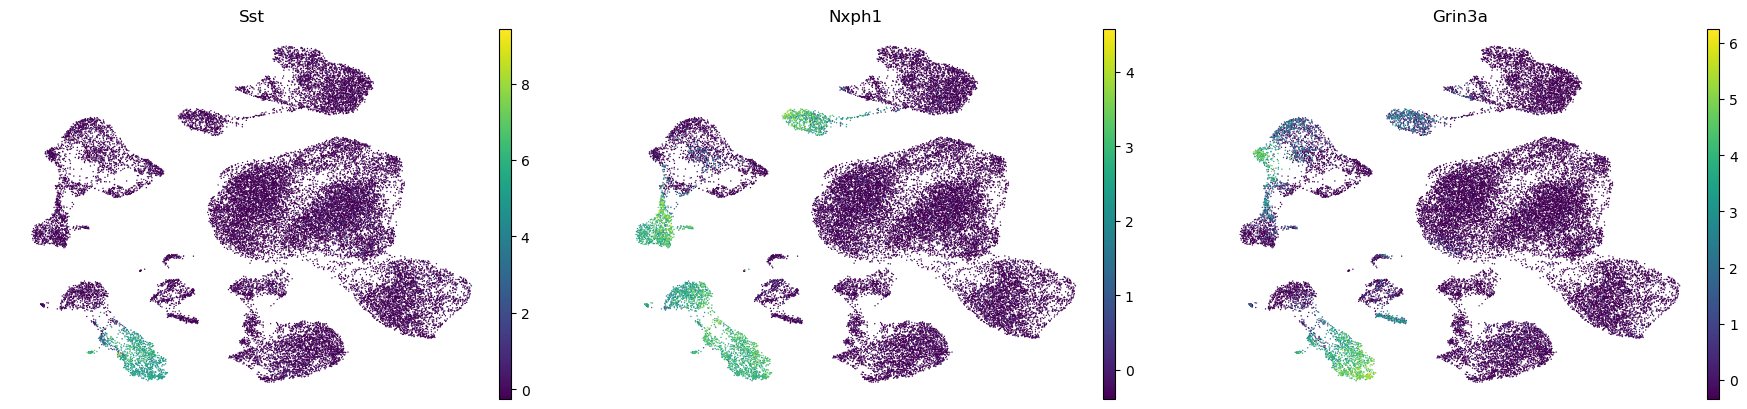

In [18]:
#The top 3 genes identified by p-values for each group are seperated
top5_df = markers.groupby("group").head(3)

#UMAP plots of each of the top 5 genes for cluster 3
genes = top5_df[top5_df['group'] == '3']['names'].tolist()
sc.pl.umap(adata, color=genes, frameon=False)

#UMAP plots of each of the top 5 genes for cluster 8
genes = top5_df[top5_df['group'] == '8']['names'].tolist()
sc.pl.umap(adata, color=genes, frameon=False)

**1.Foxp2/Slc17a7 and Sst/Gad1 were identified as top marker genes for Leiden clusters 3 and 8, respectively.**

**2.Foxp2 is known to be highly expressed in Layer 6 corticothalamic neurons, suggesting that Cluster 3 likely represents this well-characterized excitatory subtype.**

**3. Sst is a well-known marker for a specific class of inhibitory interneurons, and its restricted expression in Cluster 8 suggests that this cluster represents this distinct neuron subtype.**

## Compare our results with Allen Institute's Subclass Annotations

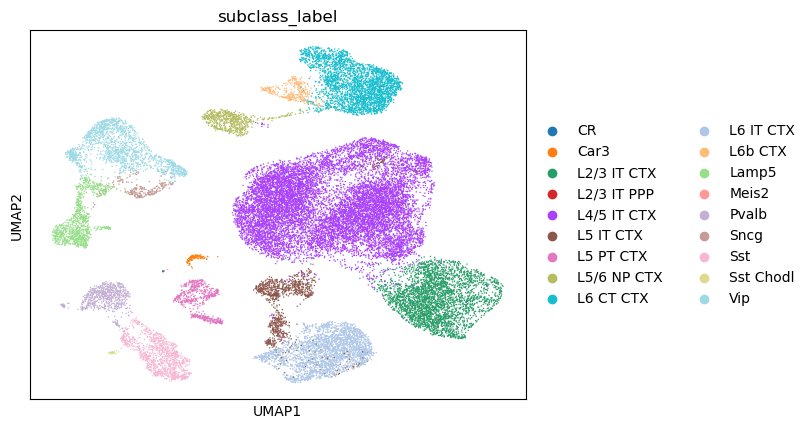

In [19]:
sc.pl.umap(adata, color = ["subclass_label"])

## Conclusion and Key Insights

**1. Clustered ~29,000 VISp neurons using UMAP and Leiden, and focused on characterizing two  distinct neuronal clusters representing major excitatory and inhibitory subtypes based on marker gene expression.**

**2. Clusters aligned well with known subclass annotations, validating the transcriptomic structure of the data.**

**3. The dataset is now ready for downstream analyses such as differential gene expression, pathway enrichment, or integration with electrophysiological and spatial transcriptomic data.**

**4. These next steps are crucial for linking molecular identity to function and understanding how diverse neuron types contribute to visual processing in the mouse primary visual cortex.**


# Appendix - Additional Confirmational Analysis

## Evaluate Silhouette Score of Clusters

In [20]:
# Compute silhouette scores in each embedding 
score_umap = silhouette_score(adata.obsm['X_umap'], adata.obs['leiden'])

# A silhouette score above 0.3 is considered good for scRNA-Seq data
print(f"Silhouette Score (UMAP): {score_umap:.3f}")

Silhouette Score (UMAP): 0.424
